In [2]:
import os
from glob import glob
import re
import logging
from tqdm import tqdm
from itertools import chain

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset,DataLoader,random_split
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A

from models import encoders, decoders
from src import datasets, utils, metrics


from torch import nn
from torch.nn import functional as F


In [3]:
from PIL import Image
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import joblib

class Eurosat(Dataset):
    """
    This class takes in the folder with RGB Eurosat data and the file names after train/test split 
    Return the image tensor and the associated class of that image
    """
    def __init__(self, path, files, transform=None, augmentations=None):
        self.img_path = path   # Path to images
        self.files = files  # list of filenames in the file path
        self.transform = transform
        self.aug = augmentations

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        # Load the image 
        img_name = self.img_path + str(self.files[idx]) # this will be something like '/scratch/yc506/eurosat_rgb/Residential_2054.tif'
        # extract the image class with the name 
        name_class = str(self.files[idx]).lower().split('_')[0] # this will give us something like 'forest'
        class_map = {'annualcrop': 0 , 'forest':1, 'herbaceousvegetation': 2, 'highway':3, 'industrial':4, 'pasture': 5, 'permanentcrop':6,
                     'residential': 7, 'river': 8, 'sealake': 9
                      }
        img_class = class_map[name_class]

        # Apply albumentations augmentations
        # before applying the standard transform
        if self.aug:
            # Must convert to numpy array for
            # this to work nicely with albumentations
            # cv2 is the recommended method for reading images.
            # although you could just convert a PIL image to
            # a numpy array, too.
            img = cv2.imread(img_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Albumentations works more nicely if you
            augmented = self.aug(image=img)
            img = augmented["image"]

        else:

            img = Image.open(img_name).convert('RGB')
            
            # Apply transforms
            if self.transform:
                img = self.transform(img)


        return img.type(torch.FloatTensor), torch.tensor(img_class, dtype=torch.int64)

In [4]:
"""
This function loads the rgb data for Eurosat
"""
def load_eurosat(data_path , size=None, evaluate=False):
    size = None

    # a list of files in the data path 
    file_set = os.listdir(data_path)
 

    # train val test split 
    train_files, rem = train_test_split(file_set, test_size=0.2, random_state = 123)
    test_files, val_files = train_test_split(rem, test_size=0.5, random_state = 123)
    
    normalize = {"mean": [44.04389265, 49.10599284, 31.27095929], "std": [41.61620523, 38.21741166, 31.96225992]}

    tr_normalize = transforms.Normalize(mean=normalize["mean"], std=normalize["std"])
    train_transform = transforms.Compose([transforms.ToTensor(), tr_normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), tr_normalize])
    train_dataset = Eurosat(data_path, train_files, transform=train_transform)
    val_dataset = Eurosat(data_path, val_files, transform=test_transform)
    # Return the training and test dataset
    test_dataset = Eurosat(data_path, test_files, transform=test_transform)
    if evaluate:
        return test_dataset

    return train_dataset, val_dataset

In [5]:
# loading the data 
train_data, test_data = load_eurosat("/scratch/yc506/NewEuroSat_rgb/" )

train_loader = DataLoader(
    train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=20, shuffle=False)

In [6]:
import torch
from torchvision.models import resnet50 as r50
from models.base import resnet

## from the encoder file 

def _append_state_dict_to_resnet(state_dict):

    # Remove keys that we don't need
    state_dict.pop("fc.bias")
    state_dict.pop("fc.weight")
    base_model = resnet.resnet50(inter_features=True)
    base_model.load_state_dict(state_dict)
    return base_model

def load_imagenet_encoder():
    """
    This model loads the weights from the SwAV model and places them
    onto this version of the ResNet model which allows the layers
    to be passed forward 
    """
    model = r50(pretrained=True)
    return _append_state_dict_to_resnet(model.state_dict())



In [7]:
####### Linear evaluation class ############
####### reference : SwAV github 
class RegLog(nn.Module):
    """Creates logistic regression on top of frozen features"""

    def __init__(self, num_labels, global_avg=False, use_bn=True):
        super(RegLog, self).__init__()
        self.bn = None
        if global_avg:
            s = 2048
            self.av_pool = nn.AdaptiveAvgPool2d((1, 1))
        else:
            s = 8192
            self.av_pool = nn.AvgPool2d(6, stride=1)
            if use_bn:
                self.bn = nn.BatchNorm2d(2048)
        self.linear = nn.Linear(s, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # average pool the final feature map
        x = self.av_pool(x)

        # optional BN
        if self.bn is not None:
            x = self.bn(x)

        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [8]:
encoder = load_imagenet_encoder()
#decoder = load_unet_decoder(encoder)
decoder = RegLog(10)
#decoder = LinearClassifier(2048, 10)

/home/yc506/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yc506/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
global DEVICE

def set_device(d):
    if d == "auto":
        device = "cuda:4" if torch.cuda.is_available() else "cpu"
    else:
        device = d
    return device

DEVICE = set_device("auto")
#DEVICE = set_device('cpu')
print("Device is " + DEVICE)
encoder = encoder.to(DEVICE)
decoder = decoder.to(DEVICE)

params = decoder.parameters()

Device is cuda:4


In [10]:
def save_model(enc, dec, dump_path, name):
    torch.save(enc.state_dict(), os.path.join(dump_path, "enc_" + name))
    torch.save(dec.state_dict(), os.path.join(dump_path, "dec_" + name))

def train(loader, encoder, decoder, optimizer, criterion, fine_tune_encoder = False):

    if fine_tune_encoder:
        encoder.train()
    else:
        encoder.eval()

    decoder.train()
    criterion = criterion.to(DEVICE)
    avg_loss = utils.AverageMeter()
    num_batches = len(loader)
    for batch_idx, (inp, target) in enumerate(loader):
        if batch_idx % 10 == 0:
            print(f"Beginning batch {batch_idx} of {num_batches}")
        logging.debug(f"Training batch {batch_idx}...")
        # Move to the GPU
        inp = inp.to(DEVICE)
        target = target.to(DEVICE)

        if fine_tune_encoder:
            output = encoder(inp)
        else:
            with torch.no_grad():
                output = encoder(inp)
        ################### The change I'm not super sure #####################
        output = decoder(output[0])
        ########################################################################
        loss = criterion(output, target)

        if batch_idx % 10 == 0:
            print(f"\t Train Loss: {loss.item()}")
        # Calculate the gradients
        optimizer.zero_grad()
        loss.backward()
        avg_loss.update(loss.item(), inp.size(0))
        # Step forward
        optimizer.step()

    return avg_loss.avg


In [11]:

@torch.no_grad()
def test(data_loader, encoder, decoder, criterion):

    encoder.eval()
    decoder.eval()
    criterion = criterion.to(DEVICE)
    avg_loss = utils.AverageMeter()
    for batch_idx, (inp, target) in enumerate(data_loader):
        # Move to the GPU
        if batch_idx % 100 == 0:
            print(f"Testing batch {batch_idx}")
        inp = inp.to(DEVICE)
        target = target.to(DEVICE)

        # Compute output
        
        ################### The change I'm not super sure #####################
        output = encoder(inp)
        output = decoder(output[0])
        ########################################################################
        loss = criterion(output, target)
        avg_loss.update(loss.item(), inp.size(0))
        if batch_idx % 10 == 0:
            print(f"\t Test Loss: {loss.item()}")

    return avg_loss.avg


In [15]:
# probably needs to change
optimizer = torch.optim.Adam(
    decoder.parameters(), lr=1e-3, weight_decay=0)

In [14]:
criterion =  nn.CrossEntropyLoss().to(DEVICE)


In [16]:

criterion =  nn.CrossEntropyLoss().to(DEVICE)
monitor_pth = "/home/yc506/ssrs/experiments/results/eurosat"

epoch_timer = utils.Timer()
monitor = utils.PerformanceMonitor(monitor_pth)
best_test_loss = float("inf")
# do 100 epochs
for epoch in range(100):
    print(f"Beginning epoch {epoch}")
    logging.info(f"Beginning epoch {epoch}...")

    loss = train(train_loader, encoder, decoder, optimizer, criterion)
    monitor.log(epoch, "train", loss)

    loss = test(test_loader, encoder, decoder, criterion)
    monitor.log(epoch, "val", loss)
    logging.info(
        f"Epoch {epoch} took {epoch_timer.minutes_elapsed()} minutes.")
    epoch_timer.reset()

    if loss < best_test_loss:
        logging.info("Saving model")
        save_model(encoder, decoder, monitor_pth, "best.pt")
        best_test_loss = loss
save_model(encoder, decoder, monitor_pth, "final.pt")



Beginning epoch 0
Beginning batch 0 of 587
	 Train Loss: 1.18072509765625
Beginning batch 10 of 587
	 Train Loss: 1.86824631690979
Beginning batch 20 of 587
	 Train Loss: 1.5359995365142822
Beginning batch 30 of 587
	 Train Loss: 1.1719727516174316
Beginning batch 40 of 587
	 Train Loss: 2.218604564666748
Beginning batch 50 of 587
	 Train Loss: 1.4156959056854248
Beginning batch 60 of 587
	 Train Loss: 1.8421471118927002
Beginning batch 70 of 587
	 Train Loss: 1.3225675821304321
Beginning batch 80 of 587
	 Train Loss: 2.02377986907959
Beginning batch 90 of 587
	 Train Loss: 1.287431240081787
Beginning batch 100 of 587
	 Train Loss: 1.8869425058364868
Beginning batch 110 of 587
	 Train Loss: 1.613189458847046
Beginning batch 120 of 587
	 Train Loss: 2.4869072437286377
Beginning batch 130 of 587
	 Train Loss: 1.7830921411514282
Beginning batch 140 of 587
	 Train Loss: 1.8998216390609741
Beginning batch 150 of 587
	 Train Loss: 1.5828367471694946
Beginning batch 160 of 587
	 Train Loss: 2

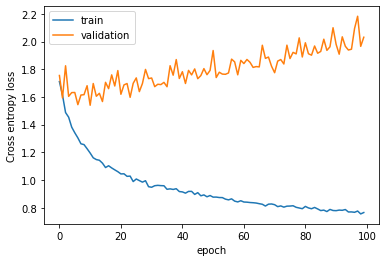

In [17]:
train_progress = pd.read_csv(os.path.join(monitor_pth,"performance.csv"))
fig,ax = .subplots()
ax.plot(train_progress.epoch[train_progress["stage"]=="train"],train_progress.loss[train_progress["stage"]=="train"],label="train")
ax.plot(train_progress.epoch[train_progress["stage"]=="val"],train_progress.loss[train_progress["stage"]=="val"],label="validation")
ax.set_xlabel("epoch")
ax.set_ylabel("Cross entropy loss")
ax.legend()
plt.show()

In [18]:
bestOrFinal = "best"
weights_folder = "/home/yc506/ssrs/experiments/results/eurosat"#"results/field_delineation_10ep/" #
encoderWeights_path = os.path.join(weights_folder,f"enc_{bestOrFinal}.pt")
decoderWeights_path = os.path.join(weights_folder,f"dec_{bestOrFinal}.pt")



In [19]:
# load the weigths we saved
encoder_trained = encoders._load_imagenet()
decoder_trained = RegLog(10)
decoder_trained.load_state_dict(torch.load(decoderWeights_path))
encoder_trained = encoder_trained.eval()
decoder_trained = decoder_trained.eval()

/home/yc506/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yc506/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
dataloader = test_loader
encoder = encoder_trained.to(DEVICE)
decoder = decoder_trained.to(DEVICE)


preds = []
targets = []
correct = 0
total = 0
for i, (img, label) in enumerate(dataloader):
    # Load through the model.
    img = img.to(DEVICE)
    label = label.to(DEVICE)
    with torch.no_grad():
        output = encoder(img)
        output = decoder(output[0])
        pred_prob = torch.sigmoid(output) #activation function sigmoid function
        _, predicted = torch.max(pred_prob, 1) # the maximum probability class will be picked as our prediction 
        total += label.size(0) # the total number of prediction 
        correct += (predicted == label).sum().item() 
        preds.append(pred_prob)
        targets.append(label) 
        
#np.array(preds),np.array(targets)

In [20]:
def get_prediction_accuracy(dataloader, encoder, decoder):
    #preds = []
    #targets = []
    correct = 0
    total = 0
    for i, (img, label) in enumerate(dataloader):
        # Load through the model.
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        with torch.no_grad():
            output = encoder(img)
            output = decoder(output[0])
            pred_prob = torch.sigmoid(output) #activation function sigmoid function
            _, predicted = torch.max(pred_prob, 1) # the maximum probability class will be picked as our prediction 
            total += label.size(0) # the total number of prediction 
            correct += (predicted == label).sum().item() 
    return correct/total 
    

In [22]:
get_prediction_accuracy(train_loader, encoder, decoder)

0.7685753237900477

In [23]:
get_prediction_accuracy(test_loader, encoder, decoder)

0.5163487738419619

In [48]:
def get_prediction(dataloader, encoder, decoder):
    preds = []
    targets = []
    correct = 0
    total = 0
    for i, (img, label) in enumerate(dataloader):
        # Load through the model.
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        with torch.no_grad():
            output = encoder(img)
            output = decoder(output[0])
            pred_prob = torch.sigmoid(output) #activation function sigmoid function
            preds.append(pred_prob.cpu())
            targets.append(label.cpu())
    return preds, targets
    

In [49]:
pred, targ = get_prediction(dataloader, encoder, decoder)